In [1]:
import torch
from torch import Tensor, nn
from typing import Collection, Tuple, Mapping
from queue import SimpleQueue
from copy import deepcopy

import MiniFL as mfl

In [2]:
def run_client(i:int, client: mfl.algorithms.gd.Client):
    for _ in range(10):
        loss = client.send_grad_get_loss()
        # print(f"Client {i}: {loss}")
        client.apply_global_step()
        
def run_master(master: mfl.algorithms.gd.Master):
    for i in range(10):
        print(f"Master: {master.round()}")

In [3]:
from sklearn.datasets import load_svmlight_file

NUM_CLIENTS = 20

data, labels = load_svmlight_file("phishing.txt")
enc_labels = labels.copy()
data_dense = data.todense()

eval_data = (torch.from_numpy(data_dense).to(torch.float32), torch.from_numpy(enc_labels).to(torch.float32)[:, None])
clients_data = [(x, y) for x, y in zip(torch.split(eval_data[0], len(eval_data[0]) // NUM_CLIENTS, dim=0), torch.split(eval_data[1], len(eval_data[1]) // NUM_CLIENTS, dim=0))]

model = torch.nn.Linear(eval_data[0].shape[1], 1, bias=False)
loss_fn = torch.nn.BCEWithLogitsLoss()

master, clients = mfl.algorithms.gd.get_master_and_clients(
    lr=200,
    clients_data=clients_data,
    eval_data=eval_data,
    model=model,
    loss_fn=loss_fn,
)

In [4]:
import threading

client_threads = []
for i, client in enumerate(clients):
    client_threads.append(threading.Thread(target=run_client, args=(i, client)))
    client_threads[-1].start()
    
master_thread = threading.Thread(target=run_master, args=(master,))
master_thread.start()

master_thread.join()
for t in client_threads:
    t.join()
    


Master: 0.6609405875205994
Master: 0.6145645380020142
Master: 0.5900835990905762
Master: 0.5639926791191101
Master: 0.54451984167099
Master: 0.5268865823745728
Master: 0.5119572877883911
Master: 0.49877506494522095
Master: 0.4871557652950287
Master: 0.47679805755615234


In [41]:
import numpy as np
import numpy.distutils.system_info as sysinfo
from numpy import linalg as la

import sys
EPS = sys.float_info.epsilon * 2

def exact(x): # No change
    var = 0
    bits = sysinfo.platform_bits * x.size
    
    return x, bits, var

def signum(x): # For sign_GD
    code = np.sign(x)
    var = (la.norm(x - code) / la.norm(x))**2
    bits = np.log2(3) * x.size
    bits = int(np.ceil(bits))
    
    return np.sign(x), bits, var

def tern_biased(aa, compute_var=True):
    a = aa.copy()
    L = np.max(np.abs(a))
    a[a > L/2] = L
    a[a < -L/2] = -L
    a[np.abs(a) <= L/2] = 0
    
    bits = min(np.count_nonzero(a) * (1 + np.log2(a.size)), np.log2(3) * a.size)
    bits = int(np.ceil(bits)) + sysinfo.platform_bits
    if compute_var:
        var = (la.norm(aa - a) / la.norm(aa))**2
    else:
        var = 0
    
    return a, bits, var

def tern_unbiased(aa, norm=np.inf, compute_var=True):
    a = aa.copy()
    a_norm = la.norm(a, ord=norm)
    prob = abs(a) / a_norm
    a = np.sign(a) * a_norm * np.random.binomial(1, prob)
    
    bits = min(np.count_nonzero(a) * (1 + np.log2(a.size)), np.log2(3) * a.size)
    bits = int(np.ceil(bits)) + sysinfo.platform_bits
    
    if compute_var:
        var = (la.norm(aa - a) / la.norm(aa))**2
    else:
        var = 0
    
    return a, bits, var

def random_sparsification(x, q=0.05): # q - fraction of nonzero elements
    d = x.size
    
    mask = np.ones(d)
    n_zeros = int(np.ceil(d * (1 - q)))
    positions = np.random.choice(d, n_zeros, replace=False)
    mask[positions] = 0
    code = mask * x # * d / q

    bits = (sysinfo.platform_bits) * (d - n_zeros)
    bits = int(np.ceil(bits))
    var = (la.norm(x - code) / la.norm(x))**2
    
    return code, bits, var


def top_k(x, q=0.05): # q - fraction of nonzero elements
    d = x.size
    k = int(np.ceil(d * q))
    
    mask = np.ones(d)
    compressed = np.ones(d)
    compressed
    
    n_zeros = int(np.ceil(d * (1 - q)))
    positions = np.argpartition(x, -k)[:-k]
    mask[positions] = 0
    code = mask * x # * d / q

    bits = (sysinfo.platform_bits) * (d - n_zeros)
    bits = int(np.ceil(bits))
    var = (la.norm(x - code) / la.norm(x))**2
    
    return code, bits, var


def natural_compression(x):
    y = np.abs(x) #/ la.norm(x)
    denominator = 2**np.floor(np.log2(y))
    p = np.maximum((2**np.ceil(np.log2(y)) - y) / denominator, 0) #np.floor(np.log2(y))
    code = np.sign(x) * denominator * (1 + np.random.binomial(1, 1 - p))
    
    if sysinfo.platform_bits == 64:
        bits = 12 * x.size
    else:
        bits = 9 * x.size
    
    var = (la.norm(x - code) / la.norm(x))**2
    
    return code, bits, var


def natural_dithering(x, s=10, norm=None, compr_norm=True):
    bits = x.size * (2 + np.log2(s)) # (2 + s)
    bits = int(np.ceil(bits))
        
    norm_x = la.norm(x, norm)
    if norm_x < EPS:
        return np.zeros_like(x), bits, 0
    
    y = np.abs(x) / norm_x
    for k in range(y.size): # I guess it is possible to vectorize it.
        if y[k] < EPS:
            y[k] = 0
        else:
            i = int(np.floor(np.log2(y[k]) + s))

            if i <= 0:
                left_lvl = 0
                right_lvl = 2**(1-s)
            else:
                left_lvl = 2**(i-s)
                right_lvl = 2**(i+1-s)

            prob = (right_lvl - y[k]) / (right_lvl - left_lvl)
            y[k] = left_lvl if np.random.binomial(1, prob) else min(1, right_lvl) # xi
            
    if compr_norm:
        compressed_norm, _, _ = natural_compression(norm_x)
        if sysinfo.platform_bits == 64:
            bits += 11
        else:
            bits += 8
    else:
        compressed_norm = norm_x
        bits += sysinfo.platform_bits
        
    code = compressed_norm * np.sign(x) * y    
    var = (la.norm(x - code) / la.norm(x))**2
    
    return code, bits, var

In [51]:
sparse_variances = []
sparse_bits = []
for q in np.linspace(0.0001, 0.15, num=100):
    for i in range(3):
        _, bit, var = random_sparsification(np.random.normal(size=(1000,)), q=q)
        sparse_variances.append(var)
        sparse_bits.append(bit / 1000)

In [52]:
top_variances = []
top_bits = []
for q in np.linspace(0.0001, 0.15, num=100):
    for i in range(3):
        _, bit, var = top_k(np.random.normal(size=(1000,)), q=q)
        top_variances.append(var)
        top_bits.append(bit / 1000)

In [ ]:
nat_dith_variances = []
nat_dith_bits = []
for s in range(2, 20):
    for i in range(3):
        _, bit, var = natural_dithering(np.random.normal(size=(1000,)), s=s)
        nat_dith_variances.append(var)
        nat_dith_bits.append(bit / 1000)

In [53]:
import matplotlib.pyplot as plt


x = np.linspace(0, 9, num=100)
y = 4**(-x)

Text(0, 0.5, 'normalized variance, $\\alpha$')

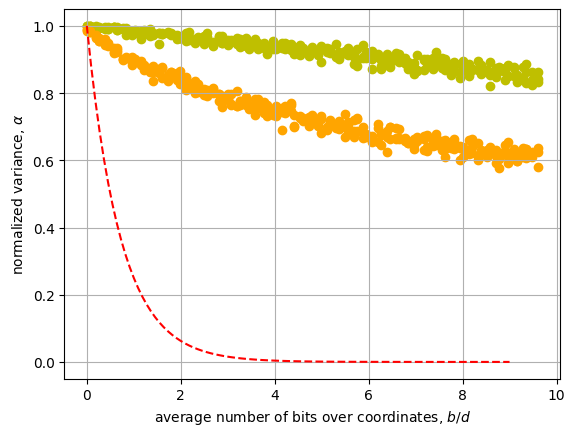

In [54]:
plt.scatter(sparse_bits, sparse_variances, color="y")
plt.scatter(top_bits, top_variances, color="orange")

plt.plot(x, y, linestyle="--", color="red")
plt.grid()
plt.xlabel(r"average number of bits over coordinates, $b/d$")
plt.ylabel(r"normalized variance, $\alpha$")